Imports

In [ ]:
import os
os.environ["OPENCV_LOG_LEVEL"] = "SILENT"
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"

import cv2
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
from keras import layers, activations
import numpy as np
import pandas as pd
from dvclive import Live
from dvclive.keras import DVCLiveCallback
import keras
from keras import metrics, losses, models, Sequential
from keras.applications.efficientnet_v2 import EfficientNetV2B0
from keras.src.applications.efficientnet_v2 import MBConvBlock, FusedMBConvBlock

from livelossplot import PlotLossesKeras

2024-02-23 15:56:13.663713: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 15:56:13.663754: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-23 15:56:13.667724: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Dataset

In [2]:
dim =64
image_size = (dim, dim)
batch_size = 150

train_ds, other = keras.utils.image_dataset_from_directory(
    "dataset/dataset_checkin",
    validation_split=0.26,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


bch = other.cardinality().numpy()
bch /= 2
test_ds, val_ds = other.take(bch), other.skip(bch)

y_test = np.concatenate([y.numpy() for _, y in test_ds])
label = {0:'left', 1:'lower', 2:'right', 3:'smile', 4:'upper'}
y_test_label = [label[i] for i in y_test]


Found 27252 files belonging to 5 classes.
Using 20167 files for training.
Using 7085 files for validation.


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


Model

In [ ]:
base_model = EfficientNetV2B0(include_top=False, input_shape=(dim, dim, 3), classes=5, include_preprocessing=False)
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(256, activation='relu')(x)
output = keras.layers.Dense(5, activation='softmax')(x)

model = keras.models.Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

model_name = str(dim) + 'Efficientnetv2B0'
model_path = 'Models/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                            filepath='checkpoint',
                            monitor='val_accuracy',
                            mode='max',
                            save_best_only=True)

with Live(exp_name=model_name) as live:
    model.fit(train_ds, validation_data=val_ds, epochs=100, batch_size=batch_size, verbose=1,
              callbacks=[PlotLossesKeras(), DVCLiveCallback(live=live), model_checkpoint_callback])
    
    model.save(model_path + model_name + '.keras')
    y_pred = model.predict(test_ds)
    y_pred = np.argmax(y_pred, axis=1)
    
    live.log_artifact(model_path + model_name + '.keras', type='model', name=model_name)
    y_pred = [label[i] for i in y_pred]
    live.log_sklearn_plot("confusion_matrix", y_test_label, y_pred, name='keras', title='keras')


Model save

In [ ]:
hist_df = pd.DataFrame(model.history.history)
hist_df.to_csv('Results/' + model_name + '.csv', index=False)

# Custom model

In [ ]:
import tensorflow as tf
from keras import Sequential, layers
dim=64

model = Sequential()

model.add(layers.Input(shape=(dim, dim, 3), dtype=tf.float32))

for n in range(2):
    model.add(layers.Conv2D(64, 3, 2, 'same', activation='relu'))
    model.add(layers.Conv2D(64, 3, 2, 'same', activation='relu'))
    model.add(layers.Conv2D(64, 3, 1, 'same', activation='relu'))
    # model.add(layers.MaxPool2D(2, 2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))

for n in range(2):
    model.add(layers.Conv2D(64, 3, 1, 'same', activation='relu'))
# model.add(layers.Conv2D(64, 4, 1, 'same', activation='relu'))
# model.add(layers.Conv2D(64, 4, 1, 'same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


## Training

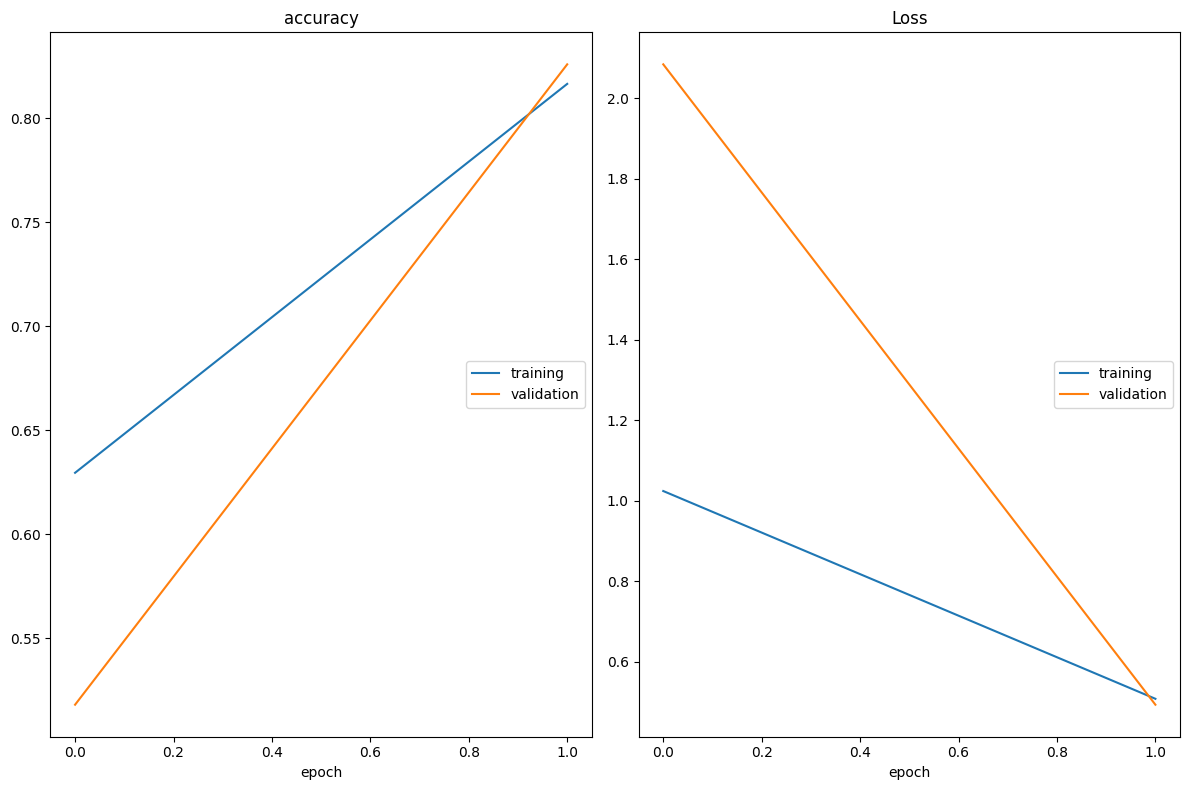

accuracy
	training         	 (min:    0.629, max:    0.816, cur:    0.816)
	validation       	 (min:    0.518, max:    0.826, cur:    0.826)
Loss
	training         	 (min:    0.509, max:    1.025, cur:    0.509)
	validation       	 (min:    0.494, max:    2.084, cur:    0.494)
135/135 [==============================] - 118s 830ms/step - loss: 0.5086 - accuracy: 0.8164 - val_loss: 0.4939 - val_accuracy: 0.8258
Epoch 3/500


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  4/135 [..............................] - ETA: 1:30 - loss: 0.4640 - accuracy: 0.8367

Invalid SOS parameters for sequential JPEG


  8/135 [>.............................] - ETA: 1:26 - loss: 0.4658 - accuracy: 0.8325

Invalid SOS parameters for sequential JPEG


  9/135 [=>............................] - ETA: 1:26 - loss: 0.4522 - accuracy: 0.8370

Invalid SOS parameters for sequential JPEG


 14/135 [==>...........................] - ETA: 1:21 - loss: 0.4346 - accuracy: 0.8448

Invalid SOS parameters for sequential JPEG


 15/135 [==>...........................] - ETA: 1:21 - loss: 0.4438 - accuracy: 0.8418

In [3]:
Folder = "224_8L524k"
model_name = str(dim) + '_8L524K'
model_path = 'Models/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                            filepath=Folder+'/checkpoint/',
                            monitor='val_accuracy',
                            mode='max',
                            save_best_only=True,
                            save_weights_only=True)


with Live(dir=Folder+ '/dvclive', dvcyaml=Folder + '/dvc.yaml',
          exp_name=model_name) as live:
    model.fit(train_ds, validation_data=val_ds, epochs=200, batch_size=batch_size, verbose=1,
              callbacks=[PlotLossesKeras(), DVCLiveCallback(live=live), model_checkpoint_callback],
              use_multiprocessing=True)
    
    model.load_weights(Folder+ '/checkpoint/')
    model.save(model_path + model_name + '.keras')
    y_pred = model.predict(test_ds)
    y_pred = np.argmax(y_pred, axis=1)
    
    live.log_artifact(model_path + model_name + '.keras', type='model', name=model_name)
    y_pred = [label[i] for i in y_pred]
    live.log_sklearn_plot("confusion_matrix", y_test_label, y_pred, name='keras', title='keras')


Inference

In [3]:
# import tensorflow as tf
# from keras import Sequential, layers
# dim=64

model = Sequential()

model.add(layers.Input(shape=(dim, dim, 3), dtype=tf.float32))

for n in range(2):
    model.add(layers.Conv2D(64, 3, 2, 'same'))
    model.add(layers.Conv2D(64, 3, 2, 'same'))
    model.add(layers.Conv2D(64, 3, 1, 'same', activation='swish'))
    # model.add(layers.MaxPool2D(2, 2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))

# for n in range(2):
model.add(layers.Conv2D(64, 3, 1, 'same'))
model.add(layers.Conv2D(64, 3, 1, 'same', activation='swish'))
# model.add(layers.Conv2D(64, 4, 1, 'same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 batch_normalization (Batch  (None, 16, 16, 64)        256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          36928     
                                                        

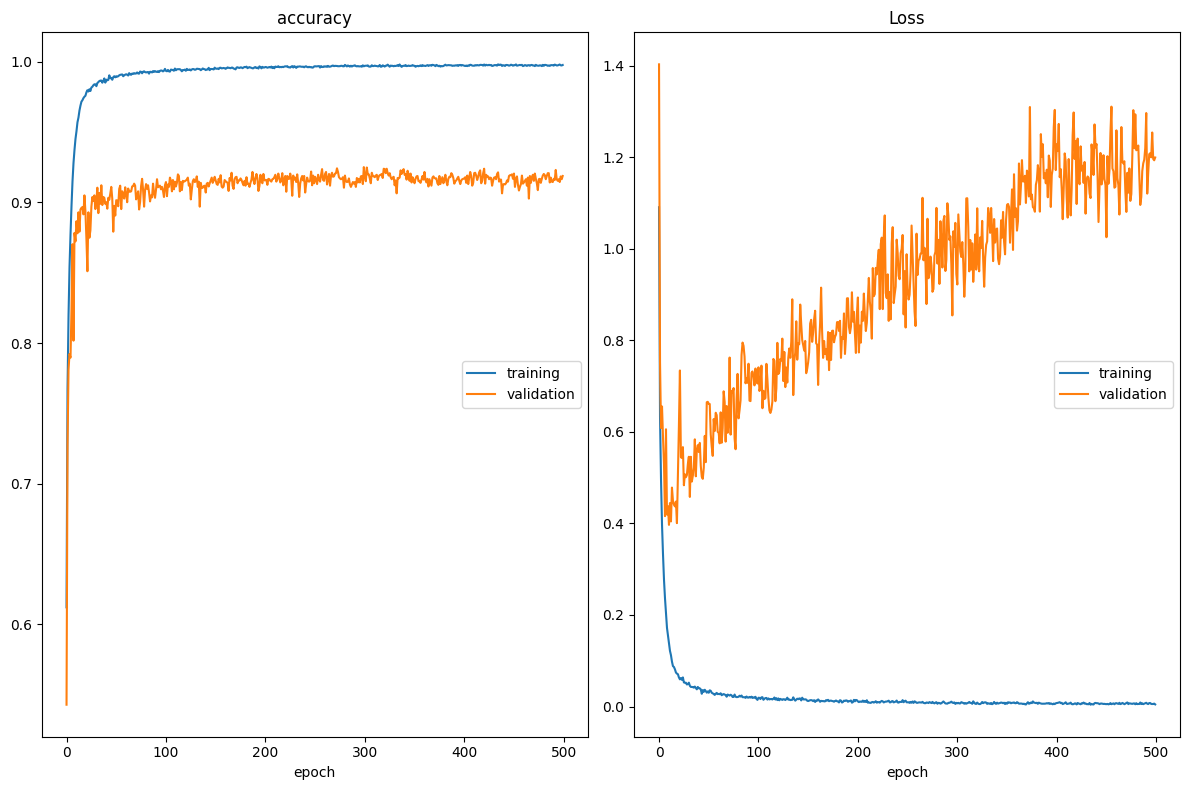

accuracy
	training         	 (min:    0.612, max:    0.998, cur:    0.998)
	validation       	 (min:    0.543, max:    0.925, cur:    0.919)
Loss
	training         	 (min:    0.004, max:    1.091, cur:    0.005)
	validation       	 (min:    0.397, max:    1.403, cur:    1.200)
135/135 [==============================] - 104s 733ms/step - loss: 0.0047 - accuracy: 0.9977 - val_loss: 1.1997 - val_accuracy: 0.9188


In [4]:
model.fit(train_ds, validation_data=val_ds, epochs=500, batch_size=batch_size, verbose=1,
              callbacks=[PlotLossesKeras()],
              use_multiprocessing=True)
    